# PTM PPI Shortcut analysis

In [1]:
import sys, pandas as pd, os, matplotlib.pyplot as plt, sklearn
from sklearn import tree

sys.path.append("../src")

all_labels = list(range(7))
pos_labels = list(range(1,7,1))

In [2]:
trainfile="../temp/train.json"
testfile="../temp/test.json"
valfile="../temp/val.json"
largescalefile = "../temp/markers_largescale_multiclass.json"


In [3]:
from model_nb_tree_classifier import ModelNBTreeClassifier
m = ModelNBTreeClassifier("PROTPART1", "PROTPART0")



In [4]:
def print_report(actual, pred, latex=True, labels=None):

    pos_f1 = sklearn.metrics.f1_score(actual, pred, labels=labels, average='micro',
                                  sample_weight=None, zero_division=0)
    all_f1 = sklearn.metrics.f1_score(actual, pred, average='micro', sample_weight=None, zero_division=0)
    print(sklearn.metrics.classification_report(actual,
                                            pred,
                                            output_dict=False,
                                            labels=labels,zero_division=0)
     )
    
    if latex:
        
        d = sklearn.metrics.classification_report(actual,
                                                pred,
                                                output_dict=True,
                                                labels=[0,1, 2, 3, 4, 5, 6],zero_division=0)
        return pd.DataFrame(d).T

In [5]:
df_train = pd.read_json(trainfile, orient="records")
m.train(df_train["x"], df_train["y"])

print_report(df_train["y"], m.predict(df_train["x"]), False, pos_labels)

print_report(df_train["y"], m.predict(df_train["x"]), False, all_labels)



              precision    recall  f1-score   support

           1       0.35      0.82      0.49       139
           2       0.21      0.79      0.34        28
           3       0.31      1.00      0.48        10
           4       0.28      1.00      0.43         5
           5       0.19      1.00      0.31         5
           6       0.50      1.00      0.67         2

   micro avg       0.31      0.84      0.45       189
   macro avg       0.31      0.93      0.45       189
weighted avg       0.33      0.84      0.47       189

              precision    recall  f1-score   support

           0       0.96      0.69      0.81      1116
           1       0.35      0.82      0.49       139
           2       0.21      0.79      0.34        28
           3       0.31      1.00      0.48        10
           4       0.28      1.00      0.43         5
           5       0.19      1.00      0.31         5
           6       0.50      1.00      0.67         2

    accuracy           

In [6]:
df_val = pd.read_json(valfile, orient="records")
print_report(df_val["y"], m.predict(df_val["x"]), False, pos_labels)

print_report(df_val["y"], m.predict(df_val["x"]), False, all_labels)




              precision    recall  f1-score   support

           1       0.36      0.76      0.48        21
           2       1.00      0.40      0.57        10
           3       0.17      1.00      0.29         1
           4       0.00      0.00      0.00         1
           5       0.00      0.00      0.00         1
           6       0.00      0.00      0.00         0

   micro avg       0.38      0.62      0.47        34
   macro avg       0.25      0.36      0.22        34
weighted avg       0.52      0.62      0.48        34

              precision    recall  f1-score   support

           0       0.94      0.81      0.87       166
           1       0.36      0.76      0.48        21
           2       1.00      0.40      0.57        10
           3       0.17      1.00      0.29         1
           4       0.00      0.00      0.00         1
           5       0.00      0.00      0.00         1
           6       0.00      0.00      0.00         0

   micro avg       0.78

In [7]:
def get_top_discrimintary_keywords(model, label_index ) :
    index_to_vocab = {i:v  for v,i in model.vocab.items()}

    return sorted( [ (index_to_vocab[i],p) for i,p in enumerate(m.nb_model.feature_log_prob_[label_index])], 
           reverse=True, key=lambda x: x[1])[:50]

get_top_discrimintary_keywords(m, 4)



[('protpart1', -3.36108738432399),
 ('protpart0', -3.657353200467162),
 ('protein', -4.4596996729921),
 ('prtig0', -4.4596996729921),
 ('degradation', -4.539742380665636),
 ('proteins', -4.6267537576552655),
 ('cell', -4.827424453117416),
 ('prtig1', -4.827424453117416),
 ('transcription', -4.9452074887738),
 ('cells', -4.9452074887738),
 ('dependent', -5.078738881398323),
 ('expression', -5.078738881398323),
 ('dna', -5.232889561225582),
 ('ubiquitin', -5.232889561225582),
 ('suppressor', -5.415211118019536),
 ('phase', -5.415211118019536),
 ('depletion', -5.415211118019536),
 ('activity', -5.415211118019536),
 ('ubiquitination', -5.415211118019536),
 ('human', -5.415211118019536),
 ('mediated', -5.415211118019536),
 ('protpart1 protpart1', -5.638354669333745),
 ('regulate', -5.638354669333745),
 ('leads', -5.638354669333745),
 ('complex', -5.638354669333745),
 ('protpart0 protpart1', -5.638354669333745),
 ('cell cycle', -5.638354669333745),
 ('ligase', -5.638354669333745),
 ('mechani

In [8]:
df_test = pd.read_json(testfile, orient="records")
print_report(df_test["y"], m.predict(df_test["x"]))




              precision    recall  f1-score   support

           0       0.95      0.79      0.86       296
           1       0.35      0.75      0.48        44
           2       0.50      0.50      0.50         6
           3       0.29      0.50      0.36         4
           4       0.00      0.00      0.00         1
           5       0.00      0.00      0.00         1

    accuracy                           0.77       352
   macro avg       0.35      0.42      0.37       352
weighted avg       0.85      0.77      0.80       352



,precision,recall,f1-score,support
0,0.947154,0.787162,0.859779,296.0
1,0.354839,0.750000,0.481752,44.0
2,0.500000,0.500000,0.500000,6.0
3,0.285714,0.500000,0.363636,4.0
4,0.000000,0.000000,0.000000,1.0
5,0.000000,0.000000,0.000000,1.0
6,0.000000,0.000000,0.000000,0.0
micro avg,0.769886,0.769886,0.769886,352.0
macro avg,0.298244,0.362452,0.315024,352.0
weighted avg,0.852595,0.769886,0.795870,352.0


In [9]:
df_largescale_hq = pd.read_json(largescalefile, orient="records")
print_report(df_largescale_hq["y"], m.predict(df_largescale_hq["x"]))



              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.89      0.94      5721
           2       0.29      0.64      0.40        42
           3       0.73      0.96      0.83        23
           4       0.50      0.20      0.29         5
           5       0.67      0.67      0.67         3

    accuracy                           0.89      5794
   macro avg       0.53      0.56      0.52      5794
weighted avg       0.99      0.89      0.93      5794



,precision,recall,f1-score,support
0,0.000000,0.000000,0.000000,0.0
1,0.997449,0.888656,0.939915,5721.0
2,0.290323,0.642857,0.400000,42.0
3,0.733333,0.956522,0.830189,23.0
4,0.500000,0.200000,0.285714,5.0
5,0.666667,0.666667,0.666667,3.0
6,0.000000,0.000000,0.000000,0.0
micro avg,0.886434,0.886434,0.886434,5794.0
macro avg,0.455396,0.479243,0.446069,5794.0
weighted avg,0.990675,0.886434,0.934860,5794.0


In [12]:
print_report(df_largescale_hq["y"], m.predict(df_largescale_hq["x"]), latex=True)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.89      0.94      5721
           2       0.29      0.64      0.40        42
           3       0.73      0.96      0.83        23
           4       0.50      0.20      0.29         5
           5       0.67      0.67      0.67         3

    accuracy                           0.89      5794
   macro avg       0.53      0.56      0.52      5794
weighted avg       0.99      0.89      0.93      5794



,precision,recall,f1-score,support
0,0.000000,0.000000,0.000000,0.0
1,0.997449,0.888656,0.939915,5721.0
2,0.290323,0.642857,0.400000,42.0
3,0.733333,0.956522,0.830189,23.0
4,0.500000,0.200000,0.285714,5.0
5,0.666667,0.666667,0.666667,3.0
6,0.000000,0.000000,0.000000,0.0
micro avg,0.886434,0.886434,0.886434,5794.0
macro avg,0.455396,0.479243,0.446069,5794.0
weighted avg,0.990675,0.886434,0.934860,5794.0


In [15]:
from sklearn.metrics import accuracy_score
accuracy_score(df_largescale_hq["y"], m.predict(df_largescale_hq["x"]))

0.886434242319641

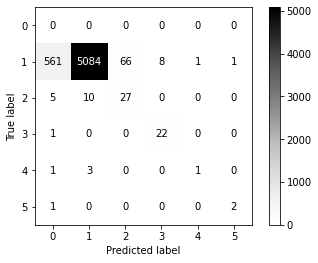

In [21]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(df_largescale_hq["y"], m.predict(df_largescale_hq["x"]))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Greys")

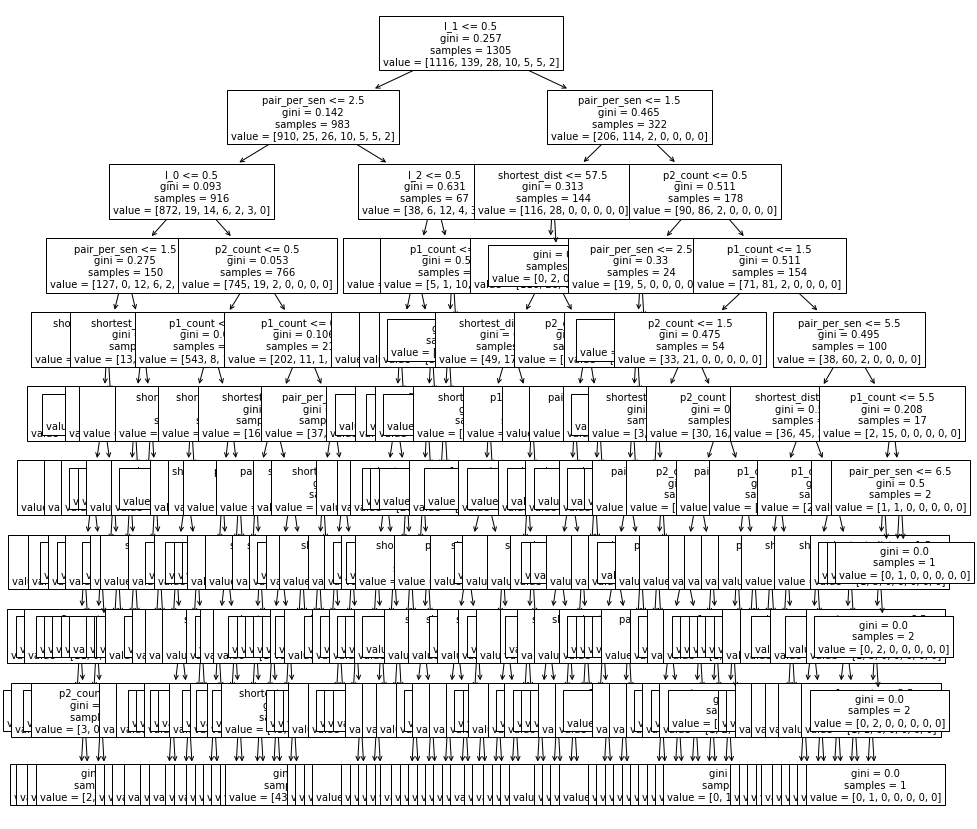

In [11]:
_, ax = plt.subplots(1,1, figsize=(15,15))

tree.plot_tree(m.tree_model, ax=ax, fontsize=10, feature_names=m.feature_names)

plt.show()

